In [1]:
import sys
from utils import data_utils
import helper
import matplotlib.pyplot as plt
from utils import training_utils
from utils import data_utils
import torch
from model import models
import json
import os
from model import lightning_models
import math
import pytorch_lightning as pl


/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
config = helper.Config("./simulations",default_config_file="./default_configs/default_config_cifar10.ini")

#config = helper.Config("./simulation_imagenet",default_config_file="./default_configs/default_config_imagenet1k.ini")

if config.INFO["fix_random_seed"]:
    pl.seed_everything(137) # To be reproducable
'''
# save the starting time as the last line
current_datetime,est_zone = helper.get_est_time_now()
if os.path.isfile(os.path.join("./simulation_imagenet","starting-time.txt")):
    with open(os.path.join("./simulation_imagenet","starting-time.txt"),"a") as f:
        f.write("\n")
        f.write(current_datetime.strftime("%Y-%m-%d %H:%M:%S"))
else:
    with open(os.path.join("./simulation_imagenet","starting-time.txt"),"a") as f:
        f.write(current_datetime.strftime("%Y-%m-%d %H:%M:%S"))
'''    

Seed set to 137


Loading default settings...
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[SemiSL]does not exist in the config file
[TL]does not exist in the config file
[INFO]
num_nodes = 1
gpus_per_node = 1
cpus_per_gpu = 4
prefetch_factor = 2
precision = 16-mixed
fix_random_seed = True
strategy = ddp
if_profile = False

[DATA]
dataset = CIFAR10
n_views = 8
augmentations = ['RandomResizedCrop', 'GaussianBlur', 'RandomGrayscale', 'ColorJitter', 'RandomHorizontalFlip']
augmentation_package = albumentations
crop_size = 32
crop_min_scale = 0.08
crop_max_scale = 1.0
hflip_prob = 0.5
blur_kernel_size = 3
blur_prob = 0.5
grayscale_prob = 0.2
jitter_brightness = 0.8
jitter_contrast = 0.8
jitter_saturation = 0.8
jitter_hue = 0.2
jitter_prob = 0.8

[SSL]
backbone = resnet18
use_projection_head = True
proj_dim = [4096]
proj_out_dim = 512
optimizer = LARS
lr = 12.2
lr_scale = linear
lr_scheduler = cosine-warmup
grad_accumulation_steps = 1
momentum = 0.0
weight_decay = 0.0001
la

'\n# save the starting time as the last line\ncurrent_datetime,est_zone = helper.get_est_time_now()\nif os.path.isfile(os.path.join("./simulation_imagenet","starting-time.txt")):\n    with open(os.path.join("./simulation_imagenet","starting-time.txt"),"a") as f:\n        f.write("\n")\n        f.write(current_datetime.strftime("%Y-%m-%d %H:%M:%S"))\nelse:\n    with open(os.path.join("./simulation_imagenet","starting-time.txt"),"a") as f:\n        f.write(current_datetime.strftime("%Y-%m-%d %H:%M:%S"))\n'

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5625
625


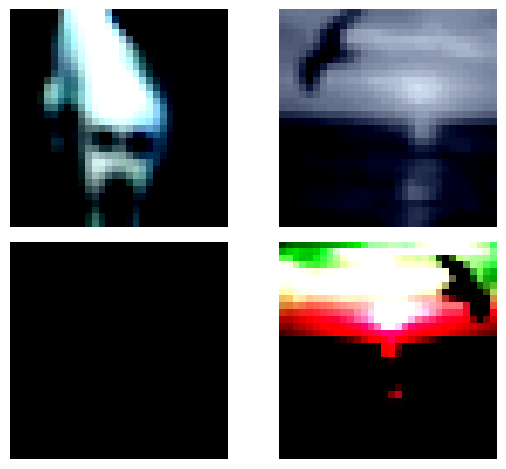

In [3]:
# for multi-gpu trainning, effective batch size = batch_size*num_gpus
ssl_batch_size = config.SSL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"]*config.SSL["grad_accumulation_steps"])
ssl_train_loader,ssl_test_loader,ssl_val_loader = data_utils.get_dataloader(config.DATA,ssl_batch_size,
                                                                                num_workers = config.INFO["cpus_per_gpu"],
                                                                                standardized_to_imagenet=True,
                                                                                augment_val_set = True,
                                                                                prefetch_factor=config.INFO["prefetch_factor"],
                                                                                aug_pkg = config.DATA["augmentation_package"])
# test_loader and val_loader are not necessary
del ssl_test_loader
imgs,labels = next(iter(ssl_train_loader))
img_list, label_list = [],[]
for i_view in range(2):
    for j_img in range(2):
        img_list.append(imgs[i_view][j_img])
        #label_list.append(classes[labels[i_view][j_img]])
data_utils.show_images(img_list,2,2,label_list)
print(len(ssl_train_loader))
print(len(ssl_val_loader))

In [4]:
if config.SSL["lr_scale"] == "linear":
    ssl_lr = config.SSL["lr"]*config.SSL["batch_size"]/256.0 # lr ~ 0.1
elif config.SSL["lr_scale"] == "sqrt":
    ssl_lr = config.SSL["lr"]*math.sqrt(config.SSL["batch_size"]) # lr ~ 0.05
if "CIFAR" in config.DATA["dataset"] or "MNIST" in config.DATA["dataset"]:
    prune_backbone = True
else:
    prune_backbone = False
ssl_model = lightning_models.CLAP(backbone_name = config.SSL["backbone"],
                                  prune = prune_backbone,
                                  use_projection_head=config.SSL["use_projection_head"],
                                  proj_dim = config.SSL["proj_dim"],
                                  proj_out_dim = config.SSL["proj_out_dim"],
                                  loss_name= config.SSL["loss_function"],
                                  optim_name = config.SSL["optimizer"],
                                  lr = ssl_lr,
                                  scheduler_name = config.SSL["lr_scheduler"],
                                  momentum = config.SSL["momentum"],
                                  weight_decay = config.SSL["weight_decay"],
                                  eta = config.SSL["lars_eta"],
                                  warmup_epochs = config.SSL["warmup_epochs"],
                                  n_epochs = config.SSL["n_epochs"],
                                  n_views = config.DATA["n_views"],
                                  batch_size = ssl_batch_size,
                                  lw0 = config.SSL["lw0"],
                                  lw1 = config.SSL["lw1"],
                                  lw2 = config.SSL["lw2"],
                                  max_mem_size = config.SSL["max_mem_size"],
                                  rs = config.SSL["rs"],
                                  pot_pow = config.SSL["pot_pow"])
'''
# check if the sub module is the same as needed
for name, module in ssl_model.backbone.named_modules():
    print(name, ":", module)
# check if the bachnorm is correctly converted to sync batchnorm


ssl_model.backbone = torch.nn.SyncBatchNorm.convert_sync_batchnorm(ssl_model.backbone)
for name, module in ssl_model.backbone.named_modules():
    if isinstance(module, torch.nn.BatchNorm2d):
        print(f"No BatchNorm2d NOT converted at: {name}")
    elif isinstance(module, torch.nn.SyncBatchNorm):
        print(f"Yes SyncBatchNorm converted at: {name}")
'''

max_mem_size is dummy for RepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for RepulsiveEllipsoidPackingLossUnitNorm


'\n# check if the sub module is the same as needed\nfor name, module in ssl_model.backbone.named_modules():\n    print(name, ":", module)\n# check if the bachnorm is correctly converted to sync batchnorm\n\n\nssl_model.backbone = torch.nn.SyncBatchNorm.convert_sync_batchnorm(ssl_model.backbone)\nfor name, module in ssl_model.backbone.named_modules():\n    if isinstance(module, torch.nn.BatchNorm2d):\n        print(f"No BatchNorm2d NOT converted at: {name}")\n    elif isinstance(module, torch.nn.SyncBatchNorm):\n        print(f"Yes SyncBatchNorm converted at: {name}")\n'

In [5]:
ssl_dir = os.path.join(config.loc,"ssl")
if not os.path.isdir(ssl_dir):
    os.makedirs(ssl_dir)
ssl_model = lightning_models.train_clap(model=ssl_model, 
                                        train_loader = ssl_train_loader,
                                        val_loader = ssl_val_loader,
                                        max_grad_norm=config.SSL["max_grad_norm"],
                                        max_epochs=config.SSL["n_epochs"],
                                        every_n_epochs = config.SSL["save_every_n_epochs"],
                                        precision = config.INFO["precision"],
                                        checkpoint_path=ssl_dir,
                                        if_profile=config.INFO["if_profile"])

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Found pretrained model at ./simulations/ssl/best_val.ckpt, loading...
max_mem_size is dummy for RepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for RepulsiveEllipsoidPackingLossUnitNorm


In [6]:
lc_batch_size = config.LC["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
data_info = {"dataset":config.DATA["dataset"],"batch_size":lc_batch_size,"n_views":1,"augmentations":["RandomResizedCrop","RandomHorizontalFlip"],
            "crop_size":config.DATA["crop_size"],"crop_min_scale":0.08,"crop_max_scale":1.0,"hflip_prob":0.5}
# need to specify the location of the data for imagenet
if "IMAGENET1K" in config.DATA["dataset"]:
    data_info["imagenet_train_dir"] = config.DATA["imagenet_train_dir"]
    data_info["imagenet_val_dir"] = config.DATA["imagenet_val_dir"]

lc_train_loader,lc_test_loader,lc_val_loader = data_utils.get_dataloader(data_info,lc_batch_size,num_workers=config.INFO["cpus_per_gpu"],
                                                                         standardized_to_imagenet=config.LC["standardize_to_imagenet"],
                                                                         prefetch_factor=config.INFO["prefetch_factor"])
# root directory for linear classification
lc_dir = os.path.join(config.loc,"lc")
if not os.path.isdir(lc_dir):
    os.makedirs(lc_dir)
if "lr_sweep" in config.LC:
    lr_list = config.LC["lr_sweep"]
else:
    lr_list = [config.LC["lr"]]
# sweep learning rates
best = {"best_test_acc1":0.0,"best_test_acc5":0.0,"best_test_loss":0.0,"best_model_dir":"none"}
for lr in lr_list:
    lc_sub_dir = os.path.join(lc_dir,"lr_{}".format(lr))
    os.makedirs(lc_sub_dir,exist_ok=True)
    if config.LC["lr_scale"] == "linear":
        lc_lr = lr*config.LC["batch_size"]/256.0 # lr ~ 0.1
    elif config.LC["lr_scale"] == "sqrt":
        lc_lr = lr*math.sqrt(config.LC["batch_size"]) # lr ~ 0.05
    # load the backbone from the check point
    best_ssl_ckpt = os.path.join(ssl_dir,"best_val.ckpt")
    ssl_model = lightning_models.CLAP.load_from_checkpoint(best_ssl_ckpt)
    ssl_model.backbone.remove_projection_head()

    lc_model = lightning_models.LinearClassification(
                 backbone = ssl_model.backbone,
                 in_dim = ssl_model.backbone.feature_dim,
                 out_dim = config.LC["output_dim"],
                 use_batch_norm = config.LC["use_batch_norm"],
                 optim_name = config.LC["optimizer"],
                 scheduler_name = config.LC["lr_scheduler"],
                 lr = lc_lr, 
                 momentum = config.LC["momentum"],
                 weight_decay = config.LC["weight_decay"],
                 n_epochs = config.LC["n_epochs"])
    
    lc_model = lightning_models.train_lc(linear_model = lc_model,
            train_loader = lc_train_loader,
            test_loader = lc_test_loader,
            val_loader = lc_val_loader,
            max_epochs = config.LC["n_epochs"],
            every_n_epochs = config.LC["save_every_n_epochs"],
            checkpoint_path = lc_sub_dir,
            precision = config.INFO["precision"],
            restart = config.LC["restart_training"])
    # get the best performed one
    with open(os.path.join(lc_sub_dir,"results.json")) as f:
        result = json.load(f)
    if result["test_acc1"] > best["best_test_acc1"]:
        best["best_test_acc1"] = result["test_acc1"] 
        best["best_test_acc5"] = result["test_acc5"] 
        best["best_test_loss"] = result["test_loss"]
        best["best_model_dir"] = lc_sub_dir
#save the information about the best model
with open(os.path.join(lc_dir,"results.json"),"w") as f:
    json.dump(best,f,indent=4)  
    

Files already downloaded and verified
Files already downloaded and verified


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/richard/Documents/code/clap/simulations/lc/lr_0.3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | backbone   | BackboneNet | 11.2 M | train
1 | linear_net | Linear      | 5.1 K  | train
-----------

max_mem_size is dummy for RepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for RepulsiveEllipsoidPackingLossUnitNorm


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (43) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

loss = 6.915245532989502
loss = 6.778806209564209
loss = 6.480193138122559
loss = 6.699606895446777
loss = 6.43653678894043
loss = 6.984192848205566
loss = 6.64966344833374
loss = 6.583913803100586
loss = 6.659305095672607
# of batches in the test = 9 !!!!!!!!!!!!!!!!!!!!!
[{'test_loss': tensor(6.9152, device='cuda:0'), 'test_acc1': tensor(0.3262, device='cuda:0'), 'test_acc5': tensor(0.8330, device='cuda:0')}, {'test_loss': tensor(6.7788, device='cuda:0'), 'test_acc1': tensor(0.3271, device='cuda:0'), 'test_acc5': tensor(0.8350, device='cuda:0')}, {'test_loss': tensor(6.4802, device='cuda:0'), 'test_acc1': tensor(0.3457, device='cuda:0'), 'test_acc5': tensor(0.8418, device='cuda:0')}, {'test_loss': tensor(6.6996, device='cuda:0'), 'test_acc1': tensor(0.3350, device='cuda:0'), 'test_acc5': tensor(0.8369, device='cuda:0')}, {'test_loss': tensor(6.4365, device='cuda:0'), 'test_acc1': tensor(0.3398, device='cuda:0'), 'test_acc5': tensor(0.8691, device='cuda:0')}, {'test_loss': tensor(6.98

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/richard/Documents/code/clap/simulations/lc/lr_0.1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | backbone   | BackboneNet | 11.2 M | train
1 | linear_net | Linear      | 5.1 K  | train
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


max_mem_size is dummy for RepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for RepulsiveEllipsoidPackingLossUnitNorm


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

loss = 2.6319165229797363
loss = 2.706904411315918
loss = 2.5495355129241943
loss = 2.598628520965576
loss = 2.5003774166107178
loss = 2.7030575275421143
loss = 2.68558669090271
loss = 2.548868179321289
loss = 2.558499574661255
# of batches in the test = 9 !!!!!!!!!!!!!!!!!!!!!
[{'test_loss': tensor(2.6319, device='cuda:0'), 'test_acc1': tensor(0.3398, device='cuda:0'), 'test_acc5': tensor(0.8506, device='cuda:0')}, {'test_loss': tensor(2.7069, device='cuda:0'), 'test_acc1': tensor(0.3525, device='cuda:0'), 'test_acc5': tensor(0.8252, device='cuda:0')}, {'test_loss': tensor(2.5495, device='cuda:0'), 'test_acc1': tensor(0.3633, device='cuda:0'), 'test_acc5': tensor(0.8477, device='cuda:0')}, {'test_loss': tensor(2.5986, device='cuda:0'), 'test_acc1': tensor(0.3730, device='cuda:0'), 'test_acc5': tensor(0.8447, device='cuda:0')}, {'test_loss': tensor(2.5004, device='cuda:0'), 'test_acc1': tensor(0.3486, device='cuda:0'), 'test_acc5': tensor(0.8740, device='cuda:0')}, {'test_loss': tensor

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/richard/miniconda3/envs/dl_env/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/richard/Documents/code/clap/simulations/lc/lr_0.05 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | backbone   | BackboneNet | 11.2 M | train
1 | linear_net | Linear      | 5.1 K  | train
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


max_mem_size is dummy for RepulsiveEllipsoidPackingLossUnitNorm
lw2 is dummy for RepulsiveEllipsoidPackingLossUnitNorm


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
lc_dir

In [ ]:
# Fine-tune or semi-supervised learning
if len(config.SemiSL) > 0:
    semisl_batch_size = config.SemiSL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
    for dataset in ["IMAGENET1K-1percent","IMAGENET1K-10percent"]:
        data_info = {"dataset":dataset,"batch_size":semisl_batch_size,"n_views":1,"augmentations":["RandomResizedCrop","RandomHorizontalFlip"],
                 "crop_size":config.DATA["crop_size"],"crop_min_scale":0.08,"crop_max_scale":1.0,"hflip_prob":0.5}
        # add the location for imagenet dataset
        data_info["imagenet_train_dir"] = config.DATA["imagenet_train_dir"]
        data_info["imagenet_val_dir"] = config.DATA["imagenet_val_dir"]
        
        semisl_train_loader,semisl_test_loader,semisl_val_loader = data_utils.get_dataloader(data_info,semisl_batch_size,num_workers=config.INFO["cpus_per_gpu"],
                                                                                 standardized_to_imagenet=config.SemiSL["standardize_to_imagenet"],
                                                                                 prefetch_factor=config.INFO["prefetch_factor"])
        semisl_dir = os.path.join(config.loc,"semisl-"+dataset)
        if not os.path.isdir(semisl_dir):
            os.makedirs(semisl_dir)
        if "lr_sweep" in config.SemiSL:
            lr_list = config.SemiSL["lr_sweep"]
        else:
            lr_list = [config.SemiSL["lr"]]
        # sweep learning rates
        best = {"best_test_acc1":0.0,"best_test_acc5":0.0,"best_test_loss":0.0,"best_model_dir":"none"}
        for lr in lr_list:
            semisl_sub_dir = os.path.join(semisl_dir,"lr_{}".format(lr))
            os.makedirs(semisl_sub_dir,exist_ok=True)
            if config.SemiSL["lr_scale"] == "linear":
                semisl_lr = lr*config.SemiSL["batch_size"]/256.0 # lr ~ 0.1
            elif config.SemiSL["lr_scale"] == "sqrt":
                semisl_lr = lr*math.sqrt(config.SemiSL["batch_size"]) # lr ~ 0.05
            # load the backbone from the checkpoint
            best_ssl_ckpt = os.path.join(ssl_dir,"best_val.ckpt")
            ssl_model = lightning_models.CLAP.load_from_checkpoint(best_ssl_ckpt)
            ssl_model.backbone.remove_projection_head()
            # load the best linear classifier from the checkpoint
            with open(os.path.join(lc_dir,"results.json")) as f:
                results = json.load(f)
                best_lc_dir = results["best_model_dir"] 
            lc_model = lightning_models.LinearClassification.load_from_checkpoint(os.path.join(best_lc_dir,"best_val.ckpt"),backbone = ssl_model.backbone)
            semisl_model = lightning_models.FineTune(backbone = ssl_model.backbone,
                    linear_net= lc_model.linear_net,
                    optim_name = config.SemiSL["optimizer"],
                    lr = semisl_lr, 
                    momentum = config.SemiSL["momentum"],
                    weight_decay = config.SemiSL["weight_decay"],
                    n_epochs = config.SemiSL["n_epochs"])
            semisl_model = lightning_models.train_finetune(
                    finetune_model = semisl_model,
                    train_loader = semisl_test_loader,
                    test_loader = semisl_test_loader,
                    val_loader = semisl_val_loader,
                    max_epochs = config.SemiSL["n_epochs"],
                    every_n_epochs = config.SemiSL["save_every_n_epochs"],
                    checkpoint_path = semisl_sub_dir,
                    precision= config.INFO["precision"],
                    restart = config.SemiSL["restart_training"])
            # get the best performed one
            with open(os.path.join(semisl_sub_dir,"results.json")) as f:
                result = json.load(f)
            if result["test_acc1"] > best["best_test_acc1"]:
                best["best_test_acc1"] = result["test_acc1"] 
                best["best_test_acc5"] = result["test_acc5"] 
                best["best_test_loss"] = result["test_loss"]
                best["best_model_dir"] = semisl_sub_dir
        #save the information about the best model
        with open(os.path.join(semisl_dir,"results.json"),"w") as f:
            json.dump(best,f,indent=4)  
            

In [1]:
# Transfer learning(freeze backbone)
if len(config.TL) > 0:
    tl_output_dim = {"CIFAR100":100,
                    "FOOD101":101,
                    "FLOWERS102":102}
    for dataset in ["CIFAR100","FOOD101","FLOWERS102"]:
        tl_batch_size = config.TL["batch_size"] // (config.INFO["num_nodes"]*config.INFO["gpus_per_node"])
        data_info = {"dataset":dataset,"batch_size":semisl_batch_size,"n_views":1,"augmentations":["RandomResizedCrop","RandomHorizontalFlip"],
                 "crop_size":config.DATA["crop_size"],"crop_min_scale":0.08,"crop_max_scale":1.0,"hflip_prob":0.5}
        tl_train_loader,tl_test_loader,tl_val_loader = data_utils.get_dataloader(data_info,lc_batch_size,num_workers=config.INFO["cpus_per_gpu"],
                                                                                 standardized_to_imagenet=config.TL["standardize_to_imagenet"],
                                                                                 prefetch_factor=config.INFO["prefetch_factor"])
        tl_dir = os.path.join(config.loc,"tl-"+dataset)
        if not os.path.isdir(tl_dir):
            os.makedirs(tl_dir)
        if "lr_sweep" in config.SemiSL:
            lr_list = config.SemiSL["lr_sweep"]
        else:
            lr_list = [config.SemiSL["lr"]]
        # sweep learning rates
        best = {"best_test_acc1":0.0,"best_test_acc5":0.0,"best_test_loss":0.0,"best_model_dir":"none"}
        for lr in lr_list:
            tl_sub_dir = os.path.join(tl_dir,"lr_{}".format(lr))
            os.makedirs(tl_sub_dir,exist_ok=True)
            if config.TL["lr_scale"] == "linear":
                tl_lr = lr*config.TL["batch_size"]/256.0 # lr ~ 0.1
            elif config.TL["lr_scale"] == "sqrt":
                tl_lr = lr*math.sqrt(config.TL["batch_size"]) # lr ~ 0.05
            # load the backbone from the checkpoint
            best_ssl_ckpt = os.path.join(ssl_dir,"best_val.ckpt")
            ssl_model = lightning_models.CLAP.load_from_checkpoint(best_ssl_ckpt)
            ssl_model.backbone.remove_projection_head()
        
            tl_model = lightning_models.LinearClassification(
                    backbone = ssl_model.backbone,
                    in_dim = ssl_model.backbone.feature_dim,
                    out_dim = tl_output_dim[dataset],
                    use_batch_norm = config.TL["use_batch_norm"],
                    optim_name = config.TL["optimizer"],
                    lr = tl_lr, 
                    scheduler_name= config.TL["lr_scheduler"],
                    momentum = config.TL["momentum"],
                    weight_decay = config.TL["weight_decay"],
                    n_epochs = config.TL["n_epochs"])

            tl_model = lightning_models.train_lc(
                    linear_model = tl_model,
                    train_loader = tl_train_loader,
                    val_loader = tl_val_loader,
                    test_loader = tl_test_loader,
                    every_n_epochs = config.TL["save_every_n_epochs"],
                    max_epochs = config.TL["n_epochs"],
                    precision = config.INFO["precision"],
                    checkpoint_path = tl_sub_dir,
                    restart = config.LC["restart_training"]) 
                        # get the best performed one
            with open(os.path.join(tl_sub_dir,"results.json")) as f:
                result = json.load(f)
            if result["test_acc1"] > best["best_test_acc1"]:
                best["best_test_acc1"] = result["test_acc1"] 
                best["best_test_acc5"] = result["test_acc5"] 
                best["best_test_loss"] = result["test_loss"]
        #save the information about the best model
        with open(os.path.join(tl_dir,"results.json"),"w") as f:
            json.dump(best,f,indent=4)  

NameError: name 'config' is not defined